In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import itertools
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# Data preparation

In [ ]:
df = pd.read_csv('sentratio_and_price_closetoclose_adj2_v2.csv', index_col='date')

tickers = df['ticker'].unique()
tickers = np.delete(tickers, -2) # Remove Twitter

Dataframe return

In [4]:
df_returns = pd.DataFrame()

for tic in tickers:
    df_returns[tic] = df.loc[df['ticker'] == tic, 'daily_return']

df_returns.dropna(inplace=True)

Dataframe polarity

In [5]:
df_polarity = pd.DataFrame()

for tic in tickers:
    df_polarity[tic] = df.loc[df['ticker'] == tic, 'Polarity']


In [6]:
df_returns.index = pd.to_datetime(df_returns.index)
df_polarity.index = pd.to_datetime(df_polarity.index)
common_dates = df_returns.index.intersection(df_polarity.index)
df_returns = df_returns.loc[common_dates]
df_polarity = df_polarity.loc[common_dates]

Market values of the tickers dataframe 

In [7]:
df_mv = pd.read_excel('mv_polarity.xlsx')
df_mv = df_mv.set_index(df_mv['Date'])
df_mv.drop(columns='Date', inplace=True)
df_mv.dropna(inplace=True)
df_mv.columns = df_returns.columns
df_mv.index = df_mv.index.tz_localize('UTC') 
df_mv.index.name = 'date' 
df_mv = df_mv.loc[common_dates]


In [8]:
df_mv = df_mv.transpose()
total_monthly_value = df_mv.sum(axis=0)
vw_monthly_weights = pd.DataFrame()
for column in df_mv.columns:
    vw_monthly_weights[f'{column}'] = df_mv[column] / total_monthly_value[column]
x0 = vw_monthly_weights.transpose()
x0.columns = df_polarity.columns

In [ ]:
vcv = df_returns.loc['2014-09-22':'2017-12-31'].cov()  # Variance covariance matrix
vcv = vcv.values
returns_x0_past = (df_returns.loc['2014-09-22':'2017-12-31'].values * x0.loc['2014-09-22':'2017-12-31']).sum(axis=1)

In [10]:
import datetime
import pandas_datareader as pdr
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
rf = pdr.get_data_fred('DFF', start, end)
rf.index = rf.index.tz_localize('UTC')  # Add the UTC timezone
rf.index.name = 'date'  # Rename the index to match df_returns
rf = rf[rf.index.isin(common_dates)]
rf = rf / 100 / 252

In [11]:
x0_future = x0.loc['2018-01-02':'2020-03-23']
rf_future = rf.loc['2018-01-02':'2020-03-23']

In [12]:
tau = 0.05

In [13]:
def QP(x, sigma, mu, gamma ):
    
    v = 0.5 * x.T @ sigma @ x - gamma * x.T @ mu
    
    return v

In [14]:
def gamma_matrix(tau):
    gamma_matrix = tau * vcv
    
    return gamma_matrix

In [15]:
def calculate_implied_mu(vcv, x0, rf, gamma):
    ones = np.ones(18)
    r_vector = rf.values.item() * ones
    mu = r_vector.reshape(-1, 1) + (1 / gamma) * vcv @ x0.values.reshape(-1, 1)
    mu = mu.flatten() 
    return mu


In [16]:
gam = 1 / 20
mu_tilda_rows = []  # Create a list to store rows

for i in range(x0_future.shape[0]):  # Iterate over all rows in x0_future
    mu_row = calculate_implied_mu(vcv, x0_future.iloc[i], rf_future.iloc[i], gam)  # Calculate mu for row
    mu_tilda_rows.append(pd.Series(mu_row, name=x0_future.index[i]))  # Append as Series to list

# Combine all rows into a DataFrame
mu_tilda = pd.concat(mu_tilda_rows, axis=1).T  # Transpose to get rows in proper orientation
mu_tilda.columns = x0_future.columns  # Set column names



# Regressions

Regression on variation of polarity(t-1/t)/return(t/t+1) for each ticker

In [17]:
# Initialize a dictionary to store beta results
beta_results = []
polarity_variation = pd.DataFrame()
next_day_return_variation = pd.DataFrame()
# Loop through each ticker
for ticker in tickers:
    # Filter data for the specific ticker and ensure no missing values
    data_filtered = df[df['ticker'] == ticker][['Polarity', 'daily_return']].dropna()

    # Calculate polarity change and return change
    data_filtered['polarity_change'] = data_filtered['Polarity'].diff()
    data_filtered['return_change'] = data_filtered['daily_return'].diff()

    # Align today's polarity change with tomorrow's return change
    data_filtered['next_day_return_change'] = data_filtered['return_change'].shift(-1)
    
    # Store data in Dataframes
    polarity_variation[ticker] = data_filtered['polarity_change']
    next_day_return_variation[ticker] = data_filtered['next_day_return_change']

    # Drop rows with NaN values after the shift
    data_filtered = data_filtered.dropna(subset=['polarity_change', 'next_day_return_change'])

    # Perform expanding rolling regression
    for end_row in range(1, len(data_filtered) + 1):
        # Subset the data up to the current expanding window
        expanding_data = data_filtered.iloc[:end_row]

        # Define independent variable (polarity change) and dependent variable (next day return change)
        X = sm.add_constant(expanding_data['polarity_change'])
        y = expanding_data['next_day_return_change']

        # Fit the regression model
        model = sm.OLS(y, X).fit()

        # Store the beta (coefficient of polarity_change) and the date for the current expanding window
        beta_results.append({
            "Ticker": ticker,
            "Date": data_filtered.index[end_row - 1],  # Current date
            "Beta": model.params['polarity_change']
        })

# Ensure that both dataframes have aligned indices
combined_df = pd.concat([polarity_variation, next_day_return_variation], axis=1)

# Drop rows where there are NaN values in either DataFrame
combined_df = combined_df.dropna()

# Split back into the original DataFrames (if necessary)
polarity_variation = combined_df.iloc[:, :polarity_variation.shape[1]]
next_day_return_variation = combined_df.iloc[:, polarity_variation.shape[1]:]

polarity_variation_18_20 = polarity_variation[820:]
next_day_return_variation = next_day_return_variation[820:]
# Convert the beta results into a DataFrame for easy handling
betas_df = pd.DataFrame(beta_results)
betas_df=betas_df.pivot(index='Date', columns='Ticker', values='Beta')

# Beta at t contains information of return t+1 so we shift to remove biase
betas_df= betas_df.shift(1).dropna()
betas_df_18_20 =betas_df.loc['2018-01-02':'2020-03-23']



In [18]:
Q = mu_tilda + polarity_variation_18_20 * betas_df_18_20

In [19]:
P=np.eye(18)
omega = np.eye(P.shape[0]) * 0.5
df_optimized_weights = pd.DataFrame()
for i in range(Q.shape[0]):
    implied_mu_loop = mu_tilda.iloc[i].values.reshape(-1,1)
    Q_loop = Q.iloc[i].values.reshape(-1,1)
    mu_bar = implied_mu_loop + (gamma_matrix(tau) @ P.T) @ np.linalg.inv(P @ gamma_matrix(tau) @ P.T + omega) @ (Q_loop - P @ implied_mu_loop)
    constraints = [LinearConstraint(np.ones(x0_future.iloc[i].shape), ub = 1), 
            LinearConstraint(-np.ones(x0_future.iloc[i].shape), ub = -1),
            LinearConstraint(np.eye(x0_future.iloc[i].shape[0]), lb = 0.03)]
    res = minimize(QP, x0_future.iloc[i], args = (vcv / np.max(np.abs(vcv)), mu_bar / np.max(np.abs(mu_bar)), gam) , options={'disp': False}, constraints = constraints)
    optimized_weights = res.x
    df_optimized_weights[i] = optimized_weights

In [20]:
df_optimized_weights = df_optimized_weights.transpose()
df_optimized_weights.index = df_returns.loc['2018-01-02':'2020-03-20'].index
df_optimized_weights.columns = df_returns.columns
df_optimized_weights

,AAPL,AMD,AMRN,AMZN,BABA,BAC,BB,FB,GLD,IWM,JNUG,MNKD,NFLX,PLUG,QQQ,SPY,TSLA,UVXY
date,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,0.193681,0.03,0.03,0.121933,0.080227,0.106708,0.03,0.096652,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.040798,0.03,0.03
2018-01-03 00:00:00+00:00,0.193213,0.03,0.03,0.123183,0.080336,0.106213,0.03,0.098176,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.038880,0.03,0.03
2018-01-04 00:00:00+00:00,0.193339,0.03,0.03,0.123029,0.080742,0.106721,0.03,0.097421,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.038749,0.03,0.03
2018-01-05 00:00:00+00:00,0.193112,0.03,0.03,0.123469,0.081915,0.106124,0.03,0.097445,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.037935,0.03,0.03
2018-01-08 00:00:00+00:00,0.192064,0.03,0.03,0.124964,0.081729,0.105254,0.03,0.098025,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.037964,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-16 00:00:00+00:00,0.213148,0.03,0.03,0.167711,0.079824,0.080439,0.03,0.068879,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.030000,0.03,0.03
2020-03-17 00:00:00+00:00,0.212718,0.03,0.03,0.170584,0.078474,0.081680,0.03,0.066544,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.030000,0.03,0.03
2020-03-18 00:00:00+00:00,0.210391,0.03,0.03,0.176529,0.078110,0.079180,0.03,0.065790,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.030000,0.03,0.03


In [21]:
vw_returns = (df_returns.loc['2018-01-03':'2020-03-23'].values * x0.loc['2018-01-02':'2020-03-23']).sum(axis=1)
vw_returns = (1 + vw_returns).cumprod()
vw_returns.index = df_returns.loc['2018-01-02':'2020-03-20'].index

In [22]:
ptf_returns = pd.DataFrame((df_returns.loc['2018-01-03':'2020-03-23'].values * df_optimized_weights.values)).sum(axis=1)

tc = 0.01

# Calculate weight changes (absolute change in weights between consecutive dates)
weight_changes = df_optimized_weights.diff().abs()

# # Calculate transaction costs for each date and stock
transaction_costs = weight_changes * tc

# # Total transaction costs for each date
total_transaction_costs = transaction_costs.sum(axis=1)

# # Adjust portfolio returns for transaction costs
net_returns = ptf_returns.values - total_transaction_costs

In [23]:
cum_returns = (1 + net_returns).cumprod()
cum_returns.index = df_returns.loc['2018-01-03':'2020-03-23'].index

In [24]:
ticker = "^GSPC"
start_date = "2018-01-02"
end_date = "2020-03-24"

# Download historical data using yfinance
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
sp500_data['Daily_Returns'] = sp500_data['Adj Close'].pct_change()
sp500_data['Daily_Returns']
cum_returns_sp500 = (1 + sp500_data['Daily_Returns']).cumprod()


[*********************100%***********************]  1 of 1 completed


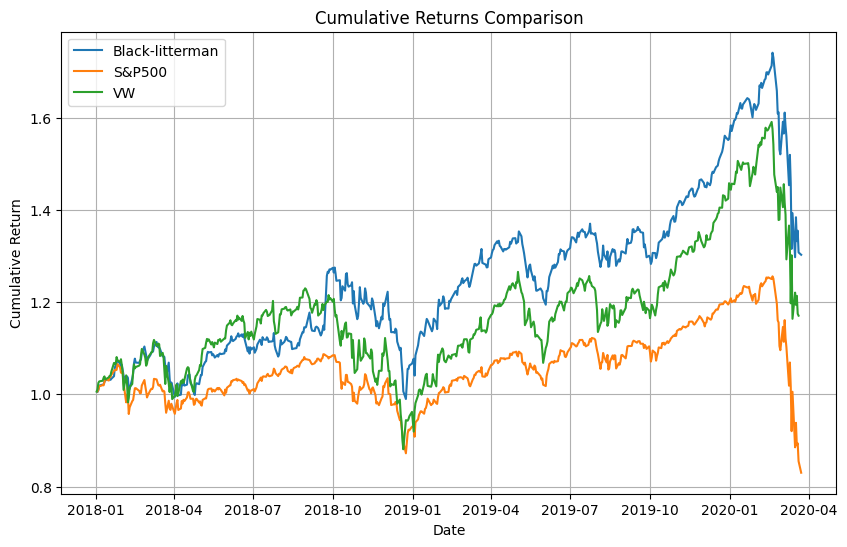

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(cum_returns, label='Black-litterman')
plt.plot(cum_returns_sp500, label='S&P500')
plt.plot(vw_returns, label='VW')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def calculate_optimized_weights(vcv,x0,rf,omega,phi,tc,constraints):
    mu_tilda_rows = []
    P = np.eye(18)
    omega_matrix = P * omega
    gamma = 1/phi
    df_optimized_weights = pd.DataFrame()
    for i in range(x0.shape[0]):  # Iterate over all rows in x0_future
        mu_row = calculate_implied_mu(vcv, x0.iloc[i], rf.iloc[i], gamma)  # Calculate mu for row
        mu_tilda_rows.append(pd.Series(mu_row, name=x0.index[i]))  # Append as Series to list

        # Combine all rows into a DataFrame
        mu_tilda = pd.concat(mu_tilda_rows, axis=1).T  # Transpose to get rows in proper orientation
        mu_tilda.columns = x0.columns
    Q = mu_tilda + polarity_variation_18_20 * betas_df_18_20    
    for i in range(Q.shape[0]):
        implied_mu_loop = mu_tilda.iloc[i].values.reshape(-1,1)
        Q_loop = Q.iloc[i].values.reshape(-1,1)
        mu_bar = implied_mu_loop + (gamma_matrix(tau) @ P.T) @ np.linalg.inv(P @ gamma_matrix(tau) @ P.T + omega_matrix) @ (Q_loop - P @ implied_mu_loop)
        constraints = constraints
        res = minimize(QP, x0.iloc[i], args = (vcv / np.max(np.abs(vcv)), mu_bar / np.max(np.abs(mu_bar)), gamma) , options={'disp': False}, constraints = constraints)
        optimized_weights = res.x
        df_optimized_weights[i] = optimized_weights
    df_optimized_weights = df_optimized_weights.transpose()
    df_optimized_weights.index = df_returns.loc['2018-01-02':'2020-03-20'].index
    df_optimized_weights.columns = df_returns.columns

    ptf_returns = pd.DataFrame((df_returns.loc['2018-01-03':'2020-03-23'].values * df_optimized_weights.values)).sum(axis=1)
    weight_changes = df_optimized_weights.diff().abs()
    transaction_costs = weight_changes * tc
    total_transaction_costs = transaction_costs.sum(axis=1)
    net_returns = ptf_returns.values - total_transaction_costs

    cum_returns = (1 + net_returns).cumprod()
    cum_returns.index = df_returns.loc['2018-01-03':'2020-03-23'].index


    return ptf_returns,cum_returns
     

In [27]:
# Define the ranges
phi_range = [1,2,3,4,5,6,7,8,9,10]  # Values for phi
tc_range = [0,0.01]  
omega_range = [0,0.1,0.2,0.3,0.4,0.5]  
# Define constraints with descriptive labels
constraints_no_min = [
    LinearConstraint(np.ones(x0_future.iloc[0].shape), ub=1), 
    LinearConstraint(-np.ones(x0_future.iloc[0].shape), ub=-1),
    LinearConstraint(np.eye(x0_future.iloc[0].shape[0]), lb=0)
]
constraints_min_1percent = [
    LinearConstraint(np.ones(x0_future.iloc[0].shape), ub=1), 
    LinearConstraint(-np.ones(x0_future.iloc[0].shape), ub=-1),
    LinearConstraint(np.eye(x0_future.iloc[0].shape[0]), lb=0.01)
]  
constraints_min_2percent = [
    LinearConstraint(np.ones(x0_future.iloc[0].shape), ub=1), 
    LinearConstraint(-np.ones(x0_future.iloc[0].shape), ub=-1),
    LinearConstraint(np.eye(x0_future.iloc[0].shape[0]), lb=0.02)
]    
constraints_min_3percent = [
    LinearConstraint(np.ones(x0_future.iloc[0].shape), ub=1), 
    LinearConstraint(-np.ones(x0_future.iloc[0].shape), ub=-1),
    LinearConstraint(np.eye(x0_future.iloc[0].shape[0]), lb=0.03)
]
constraints_short_sell_ok = [
    LinearConstraint(np.ones(x0_future.iloc[0].shape), ub=1), 
    LinearConstraint(-np.ones(x0_future.iloc[0].shape), ub=-1)
]
constraints_range = [
    {"name": "no_min", "constraints": constraints_no_min},
    {"name": "min_1percent", "constraints": constraints_min_1percent}, 
    {"name": "min_2percent", "constraints": constraints_min_2percent},
    {"name": "min_3percent", "constraints": constraints_min_3percent},
    {"name": "short_sell_ok", "constraints": constraints_short_sell_ok}
]


results = []

# Iterate over combinations of phi, tc, omega, and constraints
for phi, tc, omega, constraint_data in itertools.product(phi_range, tc_range, omega_range, constraints_range):
    constraint_name = constraint_data["name"]
    constraints = constraint_data["constraints"]


    ptf_returns, cum_returns = calculate_optimized_weights(
        vcv=vcv,
        x0=x0_future,
        rf=rf_future,
        omega=omega,
        phi=phi,
        tc=tc,
        constraints=constraints
        )
    

    results.append({
        'phi': phi,
        'tc': tc,
        'omega': omega,
        'constraint_name': constraint_name, 
        'ptf_returns': ptf_returns,
        'cum_returns': cum_returns
       
    }) 


results_df = pd.DataFrame(results)



KeyboardInterrupt: 

In [ ]:
results_df.to_pickle('df_projet.pkl')

In [ ]:

# Initialize a new DataFrame
cum_returns_df = pd.DataFrame()

# Iterate through each row in the results_df DataFrame
for index, row in results_df.iterrows():
    # Generate a unique column name using phi, tc, omega, and constraint_name
    col_name = f"phi_{row['phi']}_tc_{row['tc']}_omega_{row['omega']}_constraint_{row['constraint_name']}"
    
    # Add the cum_returns column as a new column in the new DataFrame
    cum_returns_df[col_name] = row['cum_returns']

cum_returns_df.to_csv(r'C:\Users\remyd\Desktop\HEC\Master II\QARM\Project\final\cumulative_returns.csv', index=True)


In [ ]:
pd.read_csv(r'C:\Users\remyd\Desktop\HEC\Master II\QARM\Project\final\cumulative_returns.csv',index_col='date')

,phi_1_tc_0.0_omega_0.0_constraint_no_min,phi_1_tc_0.0_omega_0.0_constraint_min_1percent,phi_1_tc_0.0_omega_0.0_constraint_min_2percent,phi_1_tc_0.0_omega_0.0_constraint_min_3percent,phi_1_tc_0.0_omega_0.0_constraint_short_sell_ok,phi_1_tc_0.0_omega_0.1_constraint_no_min,phi_1_tc_0.0_omega_0.1_constraint_min_1percent,phi_1_tc_0.0_omega_0.1_constraint_min_2percent,phi_1_tc_0.0_omega_0.1_constraint_min_3percent,phi_1_tc_0.0_omega_0.1_constraint_short_sell_ok,...,phi_10_tc_0.01_omega_0.4_constraint_no_min,phi_10_tc_0.01_omega_0.4_constraint_min_1percent,phi_10_tc_0.01_omega_0.4_constraint_min_2percent,phi_10_tc_0.01_omega_0.4_constraint_min_3percent,phi_10_tc_0.01_omega_0.4_constraint_short_sell_ok,phi_10_tc_0.01_omega_0.5_constraint_no_min,phi_10_tc_0.01_omega_0.5_constraint_min_1percent,phi_10_tc_0.01_omega_0.5_constraint_min_2percent,phi_10_tc_0.01_omega_0.5_constraint_min_3percent,phi_10_tc_0.01_omega_0.5_constraint_short_sell_ok
date,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00+00:00,1.045304,1.043670,1.035428,1.027186,1.410776e+00,1.016498,1.013914,1.011544,1.010012,0.764253,...,1.006578,1.006699,1.006652,1.006790,0.996062,1.006579,1.006699,1.006652,1.006790,0.996047
2018-01-04 00:00:00+00:00,1.039529,1.039319,1.032514,1.025687,1.362032e+00,1.020711,1.017745,1.014995,1.013088,0.811100,...,1.011618,1.011066,1.010287,1.009890,1.002680,1.011614,1.011067,1.010292,1.009891,1.002685
2018-01-05 00:00:00+00:00,1.032338,1.032744,1.026592,1.020402,1.410873e+00,1.034892,1.031387,1.028115,1.025084,0.860904,...,1.026661,1.025166,1.022940,1.021089,1.017303,1.026669,1.025169,1.022946,1.021091,1.017329
2018-01-08 00:00:00+00:00,1.047155,1.044843,1.035907,1.026967,1.794202e+00,1.048449,1.042928,1.037597,1.032522,0.854682,...,1.030853,1.028124,1.026121,1.024563,1.019246,1.030875,1.028129,1.026127,1.024565,1.019270
2018-01-09 00:00:00+00:00,1.008467,1.008970,1.003046,0.998145,2.001936e+00,1.045870,1.041410,1.036578,1.032063,0.789969,...,1.031304,1.028303,1.025908,1.023982,1.018074,1.031342,1.028309,1.025914,1.023983,1.018107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-17 00:00:00+00:00,3.142852,3.075140,2.584385,2.191618,-1.264858e-16,1.583055,1.594720,1.608929,1.618310,0.010745,...,1.206076,1.243825,1.277077,1.396735,1.277489,1.208321,1.245073,1.279727,1.397112,1.285145
2020-03-18 00:00:00+00:00,3.336196,3.190270,2.618909,2.168121,-5.153534e-16,1.587355,1.584519,1.584014,1.576536,0.007243,...,1.186263,1.219328,1.243638,1.351640,1.230385,1.188485,1.220323,1.246219,1.352006,1.237690
2020-03-19 00:00:00+00:00,3.352507,3.215515,2.647553,2.198392,1.502983e-15,1.635214,1.628678,1.624597,1.615185,0.008816,...,1.208561,1.239140,1.264438,1.377653,1.254990,1.210831,1.240149,1.267062,1.378029,1.262463
